# Energy Monitoring using atoti

In [1]:
import atoti as tt

# tell atoti to load the database containing the UI dashboards
config = tt.config.create_config(metadata_db="./metadata.db", port=63846, sampling_mode=tt.sampling.FULL)

session = tt.create_session("Emgt_nrj_monitoring_V3", config=config)

In [2]:
# creating base store from csv file type_compteurs
# this file should contain the complete list of all meters to make non-appartment meters accessible
store_type_compteurs = session.read_csv("./data/V3/type_compteur.csv",
                                       store_name="type_compteur",
                                       keys=["ID_compteur"], types={"Niveau": tt.type.STRING,"ID_unit": tt.type.STRING})

In [3]:
store_type_compteurs.head()

,Type_compteur,Unite,Type_intervalle,Type_aggregation,Niveau,ID_unit
ID_compteur,,,,,,
Facture_eau_CHF_1_Complexe Total,Facture_eau,CHF,Semaine,SUM,1,Complexe Total
Facture_chaud_CHF_1_Complexe Total,Facture_chaud,CHF,Semaine,SUM,1,Complexe Total
chaud_kWh_1_Complexe Total,chaud,kWh,Semaine,SUM,1,Complexe Total
eau_m3_1_Complexe Total,eau,m3,Semaine,SUM,1,Complexe Total
ECS_kWh_2_Groupe UAA,ECS,kWh,Jour,DIFF,2,Groupe UAA


In [4]:

# loading of metrics store from the sql db
# valeur_compteur type needs to be the same between the type in this method and the type in the sql db to make 
# in the sqldb ts is in datetime format 
# there is a known issue with date_shift function from sql because the underlying object saved is a DATE type but date_shift is waiting for a LOCAL_DATE

#store_compteurs = session.read_sql(
#    "jdbc:sqlserver://LISA-PC;databaseName=MonitoringDB",
#    "SELECT [tagName] AS ID_compteur, YEAR(ts) AS Annee, DATENAME(month,ts) AS Mois, DAY(ts) AS Jour, CONVERT(DATE, ts) as Date, [tagValue] AS valeur_compteur FROM [MonitoringDB].[dbo].[compteursV3];",
#    username="lisaW",
#    password="qDa2021",
#    store_name="compteurs",
#    keys=["ID_compteur", "Date"],
#    types={"ID_compteur":tt.type.STRING, "Date": tt.type.LOCAL_DATE, "valeur_compteur": tt.type.DOUBLE},
#)

In [5]:
# to make the date_shift method work we load the date from the csv for now
store_compteurs = session.read_csv("./data/V3/compteurs.csv",
                                       store_name="compteurs",
                                       keys=["ID_compteur", "Date"],
                                       types={"ID_compteur":tt.type.STRING, "Date": tt.type.LOCAL_DATE_TIME, "valeur_compteur": tt.type.DOUBLE})

In [6]:
store_compteurs.head()

value_diff  valeur_compteur  Annee  Mois  \
ID_compteur Date                                                            
ECS_kWh_3_1 2021-03-17 17:36:27       13.51         15013.51   2021     3   
            2021-03-18 17:36:27       15.34         15028.85   2021     3   
            2021-03-19 17:36:27       18.78         15047.63   2021     3   
            2021-03-20 17:36:27       18.83         15066.46   2021     3   
            2021-03-21 17:36:27       15.92         15082.38   2021     3   

                                 Jour  Semaine  
ID_compteur Date                                
ECS_kWh_3_1 2021-03-17 17:36:27    17       12  
            2021-03-18 17:36:27    18       12  
            2021-03-19 17:36:27    19       12  
            2021-03-20 17:36:27    20       12  
            2021-03-21 17:36:27    21       13

In [7]:
# loading of other csvfiles
store_entite_physique = session.read_csv("./data/V3/entite_physique.csv",
                                       store_name="entite_physique",
                                       keys=["ID_unit_physique"], types={"ID_unit_physique": tt.type.STRING,"Nom_unit": tt.type.STRING})

In [8]:
store_appt = session.read_csv("./data/V3/Appartements.csv",
                                       store_name="appartements",
                                       keys=["ID_appt"], 
                                      types={"ID_appt": tt.type.STRING,
                                             "Nb_pieces": tt.type.STRING,
                                             "Surface": tt.type.DOUBLE})

In [9]:
# here we join the store to create the schema and the cube
store_entite_physique.join(store_appt, mapping={"ID_unit_physique": "ID_appt"})
store_type_compteurs.join(store_entite_physique, mapping={"ID_unit": "ID_unit_physique"})
store_type_compteurs.join(store_compteurs, mapping={"ID_compteur":"ID_compteur"})

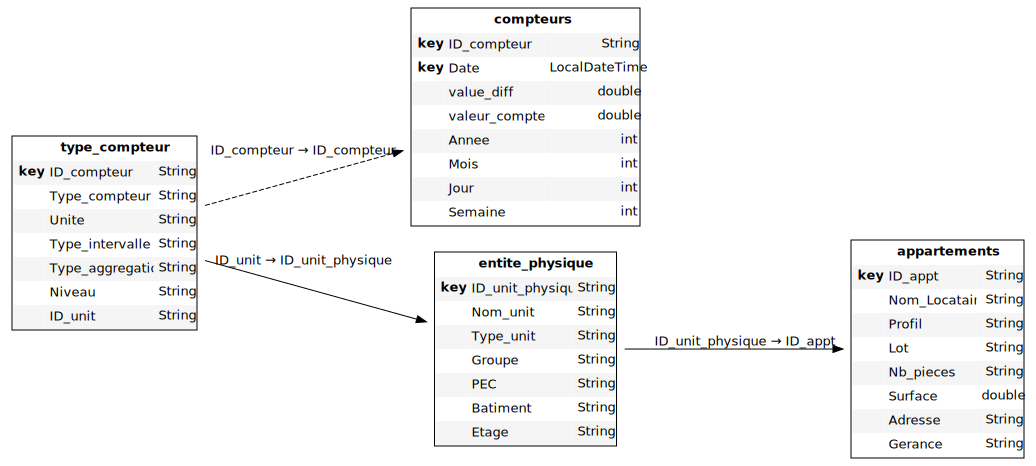

In [10]:
session.stores.schema

In [11]:
# creation of the cube allowing us to see all meters including invoice and all appartments even those without functional meters
# here the cube is created automatically = hierarchies are created for all non-numeric columns and measures for numeric-columns
cube = session.create_cube(store_type_compteurs)

In [12]:
# cleaning hierarchies and measures
cube_hierarchies, cube_measures, cube_levels   = cube.hierarchies, cube.measures, cube.levels

In [13]:
cube_hierarchies["Localisation"] = [cube_levels["Groupe"],
                                    cube_levels["PEC"] ,
                                    cube_levels["Batiment"],
                                    cube_levels["Etage"]]
del cube_hierarchies["Groupe"]
del cube_hierarchies["PEC"]
del cube_hierarchies["Batiment"]
del cube_hierarchies["Etage"]


In [14]:
# this experimental method doesn't work here so if we want to have Year/Month/Day we need to add them in the csv or the sql directly

#cube_hierarchies["Date"] = tt.experimental.create_date_hierarchy(
#    "Temps", 
#    cube,
#    store_compteurs["Date"],
#    levels={"Year": "Y", "Month": "MMMM", "Day": "d"}
#)

In [15]:
cube_hierarchies

Hierarchies()

In [16]:
# creating measures related to surface

cube_measures["Surface par appartement"] = tt.value(store_appt["Surface"], levels=[cube_levels["ID_unit"]])
cube_measures["Surface.SOMME"] = tt.agg.sum(cube_measures["Surface par appartement"])

cube_measures["Surface Totale"] = tt.total(
    cube_measures["Surface.SOMME"],
    *cube_hierarchies.values()
)
 # here test
cube_measures["Surface Batiment"] = tt.total(
    tt.filter(cube_measures["Surface.SOMME"], cube_levels["Batiment"] == "Batiment A"),
    *cube_hierarchies.values()
)

cube_measures["Surface de reference"] = tt.parent_value(
        cube_measures["Surface.SOMME"], 
        on=[cube_hierarchies["ID_unit"]],
        apply_filters=False, 
        total_value=tt.total(cube_measures["Surface.SOMME"], cube_hierarchies["Localisation"])
    )
cube_measures["Part de surface vis à vis du parent"] = cube_measures["Surface.SOMME"] / cube_measures["Surface de reference"]
cube_measures["Part de surface vis à vis du complexe"] = cube_measures["Surface.SOMME"] / cube_measures["Surface Totale"]
cube_measures["Surface.MOY"] = tt.agg.mean(store_appt["Surface"])
# format desmesures de base

cube_measures["Surface.SOMME"].formatter = "DOUBLE[0.00]"
cube_measures["Surface.MOY"].formatter = "DOUBLE[0.00]"
cube_measures["Part de surface vis à vis du parent"].formatter = "DOUBLE[0.00%]"
cube_measures["Part de surface vis à vis du complexe"].formatter = "DOUBLE[0.00%]"

cube_measures["Surface par appartement"].visible = False

In [17]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

In [18]:
# creation of the metrics value measures

cube_measures["Valeur_compteur"] = store_compteurs["valeur_compteur"]
cube_measures["Valeur_compteur.MOY"] = tt.agg.mean(cube_measures["Valeur_compteur"])
cube_measures["Valeur_compteur.MOY"].formatter = "DOUBLE[0.00]"

In [19]:
# Creation of 1 measure "Valeur_compteur.SOMME" based on type_aggregation and type_intervalle to get the direct somme of the facts 
# or the sum of diff between facts

cube_measures["Valeur_precedente_compteur"] = tt.where(
    cube_levels["Type_intervalle"] == "Jour", 
           tt.date_shift(
                cube_measures["Valeur_compteur"],
                on=cube_hierarchies["Date"],
                offset="-1D",
                method="previous"
           )  ,
            tt.date_shift(
                cube_measures["Valeur_compteur"],
                on=cube_hierarchies["Date"],
                offset="-1W",
                method="previous"
            )
)
cube_measures["Diff_valeur_compteur"] = cube_measures["Valeur_compteur"] - cube_measures["Valeur_precedente_compteur"]

# the sum depends of the aggregation type   
cube_measures["Valeur_compteur.SOMME"] = tt.agg.sum(tt.where(
    cube_levels["Type_aggregation"] == "SUM", 
    tt.agg.sum(cube_measures["Valeur_compteur"]),
    tt.agg.sum(cube_measures["Diff_valeur_compteur"])
), scope=tt.scope.origin(cube_levels["Type_aggregation"] , cube_levels["Type_intervalle"]))

cube_measures["Valeur_compteur.CUMUL.SOMME"] = tt.agg.sum(tt.where(
    cube_levels["Type_aggregation"] == "SUM", 
    tt.agg.sum(cube_measures["Valeur_compteur"], scope=tt.scope.cumulative(cube_levels["Date"])),
    tt.agg.sum(cube_measures["Diff_valeur_compteur"], scope=tt.scope.cumulative(cube_levels["Date"]))
), scope=tt.scope.origin(cube_levels["Type_aggregation"] , cube_levels["Type_intervalle"]))

cube_measures["Diff_valeur_compteur"].visible = False
cube_measures["Valeur_precedente_compteur"].visible = False

In [20]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

In [21]:
session.url

'http://localhost:63846'

In [22]:
# Creating measures for Total cost (useful to compute the cost for each appartment) 
# For that we are filtering Valeur_compteur.SOMME for the meter we want (invoice and consumption) 
# and then we are taking the total of this measure ( which is the value itself ) and we duplicate it for all hierarchies and members.  

mesure_et_filtre = {
    "Frais complexe total chaud":"Facture_chaud_CHF_1_Complexe Total",
    "Frais complexe total eau":"Facture_eau_CHF_1_Complexe Total",
    "Consommation complexe total chaud":"chaud_kWh_1_Complexe Total",
    "Consommation complexe total eau":"eau_m3_1_Complexe Total"
}

for mesure, filtre in mesure_et_filtre.items():
    cube_measures[mesure] = tt.total(
    tt.filter(cube_measures["Valeur_compteur.SOMME"], cube_levels["ID_compteur"] == filtre),
    *cube_hierarchies.values())



In [52]:
# creation of measures for each meter type useful for the rest of the computationhere we filter on type appartment as well to make sure there is no aggregation between appt meter and other type of meter
# other type of meter can be used to perform validation check or to identify unfunctional meter
conso_et_type_energie = {
    "chauffage": "chaud",
    "ECS": "chaud",
    "eau": "eau",
}
for conso, typeNrj in conso_et_type_energie.items():
    if conso == "eau": 
        cube_measures["Consommation "+conso] = tt.filter(cube_measures["Valeur_compteur.SOMME"],
                                    (cube_levels["Type_compteur"] == conso+"_froide") & (cube_levels["Type_unit"] == "Appt") )
    else :
        cube_measures["Consommation "+conso] = tt.filter(cube_measures["Valeur_compteur.SOMME"],
                                    (cube_levels["Type_compteur"] == conso) & (cube_levels["Type_unit"] == "Appt") )

    # creation of cost measures

    # total cost per energy = consumption cost per energy + fixed cost per surface contribution
    #                       = 0.7 * total cost heat * consumption_per_energy / total_heat_consumption + 0.3 * total cost heat * surface / total surface 
    cube_measures["Cout de consommation "+conso] = 0.7 * (cube_measures["Consommation "+conso] / cube_measures["Consommation complexe total "+typeNrj]) * cube_measures["Frais complexe total "+typeNrj]
    cube_measures["Cout fixe "+conso] = cube_measures["Part de surface vis à vis du complexe"] * cube_measures["Frais complexe total "+typeNrj]
    cube_measures["Cout total "+conso] = tt.where(
        cube_measures["Valeur_compteur.SOMME"] == 0, # if there is no metric value -> meters are not working
        cube_measures["Cout fixe "+conso],
        cube_measures["Cout de consommation "+conso] + 0.3 * cube_measures["Cout fixe "+conso]
    )


cube_measures["Cout total thermique"] = cube_measures["Cout total chauffage"] + cube_measures["Cout total ECS"]
cube_measures["Cout total energie et eau"] = cube_measures["Cout total thermique"] + cube_measures["Cout total eau"]

In [53]:
# creation of measures per square meter
liste_measures = ["chauffage", "ECS", "eau", "thermique", "energie et eau"]

def create_square_meter_measures(measure_type, nrj_type):
    cube_measures[measure_type+" "+nrj_type+" par m2"] =  cube_measures[measure_type+" "+nrj_type] / cube_measures["Surface.SOMME"]
    
def create_percentage_measures(measure_type, nrj_type):
    # creation of percentage to compare with parent performance
    cube_measures["Parent-"+measure_type+" "+nrj_type+" par m2"] = tt.agg._stop( tt.parent_value(
        cube_measures[measure_type+" "+nrj_type+" par m2"], 
        on=[cube_hierarchies["ID_unit"]],
        apply_filters=False, 
        total_value=cube_measures[measure_type+" "+nrj_type+" par m2"]
    ) , cube_levels["Batiment"])
    cube_measures["Parent-"+measure_type+" "+nrj_type+" par m2"].visible = False
    cube_measures["Pourcentage "+measure_type+" "+nrj_type+" par m2 par rapport au parent"] = cube_measures[measure_type+" "+nrj_type+" par m2"] /  cube_measures["Parent-"+measure_type+" "+nrj_type+" par m2"]
    cube_measures["Pourcentage "+measure_type+" "+nrj_type+" par m2 par rapport au parent"].formatter = "DOUBLE[0.00%]"

for mesure in liste_measures:
    create_square_meter_measures("Cout total", mesure)
    create_percentage_measures("Cout total", mesure)
                                                                        
    if mesure == "chauffage" or mesure == "ECS" or mesure == "eau":
        create_square_meter_measures("Consommation", mesure)
        create_percentage_measures("Consommation", mesure)

In [54]:
session.visualize()


Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

In [55]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

In [56]:
session.visualize()


Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

In [57]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.